In [1]:
import numpy as np
from scipy.special import hankel1

In [2]:
ko = 10  # Wavenumber
rad = 1. # radius of circle
lam = 2*np.pi/ko
refInd = 1.3
n_per_lam = 20  # Pixels per wavelength

h_temp = lam / n_per_lam # temp pixel dimension

wx = 2 * rad
wy = 2 * rad

# How many points in x and y directions
M = np.int(np.ceil(wx / h_temp))
N = np.int(np.ceil(wy / h_temp))

dx = wx/M;
dy = wy/N;

A = dx * dy      # pixel area
a = np.sqrt(A / np.pi) # radius of equivalent-area circle

# Get coordinates of points on grid    
x = np.zeros((M*N, 1), dtype=np.complex128);
counter= 0;
for j in range(N):
    for i in range(M):
        x[counter] = -wx/2 + dx/2+dx*i \
            - 1j*wy/2 + 1j * (dy/2+dy*j)
        counter=counter+1

x_coord = (np.arange(M)+1) * dx - dx/2 - wx/2;
y_coord = (np.arange(N)+1) * dy - dy/2 - wy/2;

In [45]:
a

0.017630924485867384

In [4]:
2*M*N

8192

In [5]:
perm = np.ones(M*N);
# Mr = np.ones((M, N));

In [6]:
idx = np.where(np.abs(x)<=rad)

In [7]:
perm[idx[0]] = refInd**2;  # assume permittivity of scatterer is 2 for now
Mr = perm - 1;

In [8]:
# Incident plane wave
dInc = np.array([1,0]);
eInc = np.zeros((M*N,1), dtype=np.complex128);
eInc[idx[0]] = np.exp(1j * ko * (np.real(x[idx[0]])*dInc[0] + np.imag(x[idx[0]]*dInc[1])))

In [9]:
MR = Mr.reshape(M,N, order='F')

In [10]:
# Fundamental solution of the Helmholtz equation
g = lambda x, y : A * 1j/4 * hankel1(0, ko*np.abs(x - y));

In [11]:
# Self term
self = a**2*1j*np.pi/2* ((1+1j*np.euler_gamma)/2-1j/np.pi+1j/np.pi*np.log(ko*a/2));

In [12]:
# Sparse matvec
toep = np.zeros((M, N), dtype=np.complex128);
for i in range(M):
    for j in range(N):
        if i == 0 and j ==0:
            toep[i,j] = self;
        else:
            toep[i,j] = g(x[0], x[j*M+i]);

In [13]:
toep = ko**2 * toep

In [14]:
circ = np.zeros((2 * M, 2 * N), dtype=np.complex128);

In [15]:
# Circulant embedding
circ[0:M, 0:N]     = toep[0:M, 0:N]
circ[0:M, N+1:2*N] = toep[0:M, -1:0:-1]
circ[M+1:2*M, 0:N]   = toep[-1:0:-1, 0:N]
circ[M+1:2*M, N+1:2*N] = toep[-1:0:-1, -1:0:-1]

In [16]:
opCirc = np.fft.fftn(circ)

In [17]:
# xx = np.random.rand(M*N, 1)
xx = np.arange(M*N)

In [18]:
X = xx.reshape(N,M).T

In [19]:
X = (xx.T).reshape(N,M).T

In [20]:
XFFT = np.fft.fftn(X, [2*M, 2*N])

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [21]:
Y = np.fft.ifftn(opCirc*XFFT)

In [22]:
xOut = Y[0:M, 0:N]

In [23]:
def mvp(xIn):#, opCirc, M, N, MR, idx):
    xInRO = xIn.reshape(M,N, order = 'F') 
    XFFT = np.fft.fftn(xInRO, [2*M, 2*N])
    Y = np.fft.ifftn(opCirc * XFFT)
    xTemp = Y[0:M, 0:N]
    xPerm = MR * xTemp
    xOutArray = xInRO - xPerm
    xOut = np.zeros((M*N, 1), dtype = np.complex128)
    xOut[idx[0]] = (xOutArray.reshape(M*N, 1, order = 'F'))[idx[0]]
    return xOut

In [24]:
from scipy.sparse.linalg import LinearOperator, gmres
A = LinearOperator((M*N, M*N), matvec=mvp)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [25]:
it_count = 0
def iteration_counter(x):
    global it_count
    it_count += 1

sol, info = gmres(A, eInc, tol=1e-4, callback=iteration_counter)
print("The linear system was solved in {0} iterations".format(it_count))

The linear system was solved in 47 iterations


/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [26]:
def mvp_domain(xIn, opCirc, M, N, MR):
    xInRO = xIn.reshape(M,N, order = 'F') 
    XFFT = np.fft.fftn(MR * xInRO, [2*M, 2*N])
    Y = np.fft.ifftn(opCirc * XFFT)
    xTemp = Y[0:M, 0:N]
    xPerm = xTemp
    xOutArray = xInRO - xPerm
    xOut = np.zeros((M*N, 1), dtype = np.complex128)
    xOut = (xOutArray.reshape(M*N, 1, order = 'F'))
    return xOut

In [27]:
mvp_eval = mvp_domain(sol, opCirc, M, N, MR)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [28]:
EINC = np.zeros((M*N,1), dtype=np.complex128);
EINC = np.exp(1j * ko * (np.real(x)*dInc[0] + np.imag(x*dInc[1])))

In [42]:
E_tot = sol.reshape(M, N, order = 'F')

In [30]:
E_tot = EINC.reshape(M, N, order = 'F') - mvp_eval.reshape(M, N, order = 'F') + sol.reshape(M, N, order = 'F')

In [31]:
kl=np.ones((M, N))

In [32]:
E = mvp_eval.reshape(M, N, order = 'F')

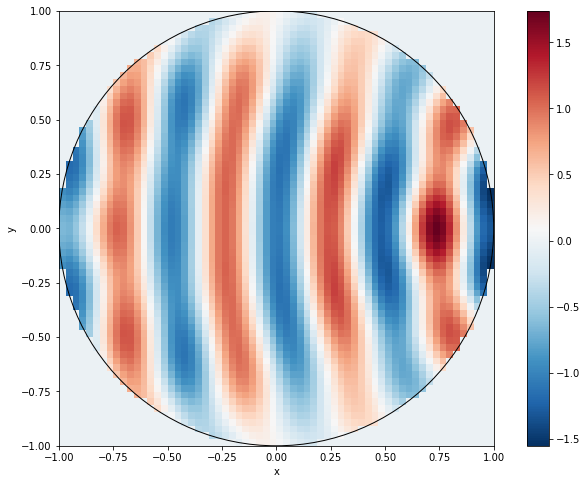

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
# plt.imshow(np.real(u_tot.T), extent=[-rad_comp,rad_comp,-rad_comp,rad_comp],cmap=plt.cm.get_cmap('coolwarm'), interpolation='spline16')
plt.imshow(np.real(E_tot.T), extent=[-wx/2,wx/2,-wy/2,wy/2],
           cmap=plt.cm.get_cmap('RdBu_r'))#, interpolation='spline16')
plt.xlabel('x')
plt.ylabel('y')
circle2 = plt.Circle((0., 0.), rad, color='black', fill=False)
ax.add_artist(circle2)
plt.colorbar()

In [34]:
ha = mvp(xx)#, opCirc, M, N, MR, idx)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [35]:
xIn = xx
xInRO = xIn.reshape(M,N, order = 'F')  # This transpose is a hack caused by different reshapes in Matlab and Python
XFFT = np.fft.fftn(xInRO, [2*M, 2*N])
Y = np.fft.ifftn(opCirc * XFFT)
xTemp = Y[0:M, 0:N]
Mr = Mr.reshape(M,N, order = 'F')
xPerm = Mr * xTemp
xOutArray = xInRO - xPerm
xOut = np.zeros((M*N, 1), dtype = np.complex128)
xOut[idx[0]] = (xOutArray.reshape(M*N, 1, order = 'F'))[idx[0]]

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [36]:
from analytical import penetrable_circle

In [37]:
xmin, xmax, ymin, ymax = [-wx/2+dx/2, wx/2-dx/2, -wy/2+dy/2, wy/2-dy/2]
plot_grid = np.mgrid[xmin:xmax:M * 1j, ymin:ymax:N * 1j]

In [38]:
ymax

0.984375

In [39]:
u_exact = penetrable_circle(ko, ko*refInd, rad, plot_grid)

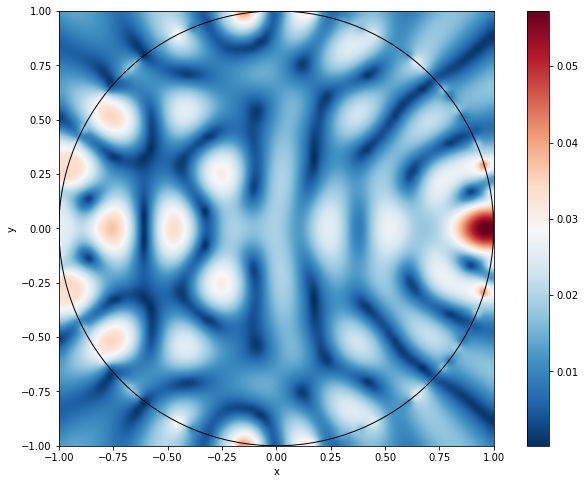

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
# plt.imshow(np.real(u_tot.T), extent=[-rad_comp,rad_comp,-rad_comp,rad_comp],cmap=plt.cm.get_cmap('coolwarm'), interpolation='spline16')
plt.imshow(np.abs((u_exact-E_tot).T), extent=[-wx/2,wx/2,-wy/2,wy/2],
           cmap=plt.cm.get_cmap('RdBu_r'), interpolation='spline16')
plt.xlabel('x')
plt.ylabel('y')
circle2 = plt.Circle((0., 0.), rad, color='black', fill=False)
ax.add_artist(circle2)
plt.colorbar()

In [41]:
error_l2 = np.linalg.norm(u_exact - E_tot) / np.linalg.norm(u_exact)
print('error = ',error_l2)

error =  0.016626401727507224
